<a href="https://colab.research.google.com/github/ckgpeace/EVA6/blob/main/Session7/Session7_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Notebook to train a CNN model on CIFAR10 dataset

### Import impoertant libraries

In [1]:
%matplotlib inline

In [2]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import numpy as np



## What about data?

Specifically for vision, we have created a package called
``torchvision``, that has data loaders for common datasets such as
Imagenet, CIFAR10, MNIST, etc. and data transformers for images, viz.,
``torchvision.datasets`` and ``torch.utils.data.DataLoader``.

This provides a huge convenience and avoids writing boilerplate code.

For this tutorial, we will use the CIFAR10 dataset.
It has the classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’,
‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. The images in CIFAR-10 are of
size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.

.. figure:: /_static/img/cifar10.png
   :alt: cifar10

   cifar10


### 1. Loading and normalizing CIFAR10


Using ``torchvision``, it’s extremely easy to load CIFAR10.



In [3]:
import torch
import torchvision

### 2. Calculate the the mean and Standard devition of the CIFAR10 data

In [4]:
from torchvision import datasets, transforms

train_transform = transforms.Compose([transforms.ToTensor()])
test_transform = transforms.Compose([transforms.ToTensor()])

# cifar10 Train
print(f"Train Statistics: \n")
train_set = datasets.CIFAR10(root='../data/', train=True, download=True, transform=train_transform)
print(train_set.data.shape)
print(train_set.data.mean(axis=(0,1,2))/255)
print(train_set.data.std(axis=(0,1,2))/255)

# cifar10 test
print(f"Test Statistics: \n")
test_set = datasets.CIFAR10(root='../data/', train=False, download=True, transform=test_transform)
print(test_set.data.shape)
print(test_set.data.mean(axis=(0,1,2))/255)
print(test_set.data.std(axis=(0,1,2))/255)

Train Statistics: 




Extracting ../data/cifar-10-python.tar.gz to ../data/
(50000, 32, 32, 3)
[0.49139968 0.48215841 0.44653091]
[0.24703223 0.24348513 0.26158784]
Test Statistics: 

Files already downloaded and verified
(10000, 32, 32, 3)
[0.49421428 0.48513139 0.45040909]
[0.24665252 0.24289226 0.26159238]


### 3. Use latest Albumentations library for Data Augmentation
Link to github - https://github.com/albu/albumentations

In [5]:
# To run the latest Albumentations library
!pip install -U git+https://github.com/albu/albumentations --no-cache-dir
# ! pip install albumentations==0.4.6

# Albumentations Transforms
# Transformations - HorizontalFlip, ShiftScaleRotate, CoarseDropout, ToGray

# from DA_albumentations import albumentations_transforms



import numpy as np
import albumentations as A
import torchvision.transforms as transforms
from albumentations.pytorch import ToTensorV2

def albumentations_transforms(p=1.0, is_train=False):
	# Mean and standard deviation of train dataset
	mean = np.array([0.49139968, 0.48215841, 0.44653091])
	std = np.array([0.24703223, 0.24348513, 0.26158784])
	transforms_list = []
	# Use data aug only for train data
	if is_train:
		transforms_list.extend([
			A.HorizontalFlip(),
            A.ShiftScaleRotate(rotate_limit=15),
            A.CoarseDropout(max_holes=1, max_height=16, max_width=1, min_holes=1, min_height=4, min_width=1, fill_value=[0.49139968, 0.48215841, 0.44653091], p=0.25),
            A.ToGray(p=0.25)
		])
	transforms_list.extend([A.Normalize(mean=mean,std=std), 
                            ToTensorV2()
                         ])
	transformed = A.Compose(transforms_list, p=p)
	return lambda img:transformed(image=np.array(img))["image"]

  Cloning https://github.com/albu/albumentations to /tmp/pip-req-build-8w7prrst
  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-8w7prrst
  Created wheel for albumentations: filename=albumentations-1.0.0-cp37-none-any.whl size=98531 sha256=bdedb61f8648d391e2fdd66c0431a4bbdc76b488ffe62fed0c8cbe68dc305905
  Stored in directory: /tmp/pip-ephem-wheel-cache-wf929yx8/wheels/45/8b/e4/2837bbcf517d00732b8e394f8646f22b8723ac00993230188b
Successfully built albumentations
  Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


### 4. Create Train and test loaders using albumentations_transforms
The output of torchvision datasets are PILImage images of range [0, 1].
We transform them to Tensors of normalized range [-1, 1].



In [6]:
# Train Data Transformations
train_transform = albumentations_transforms(p=1.0, is_train=True)

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=train_transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=32,
                                          shuffle=True, num_workers=4, pin_memory= True)


# Train Data Transformations
test_transform = albumentations_transforms(p=1.0, is_train=False)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=test_transform)

testloader = torch.utils.data.DataLoader(testset, batch_size=32,
                                         shuffle=False, num_workers=4, pin_memory= True)

# CIFAR-10 classes
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Extracting ./data/cifar-10-python.tar.gz to ./data


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Files already downloaded and verified


### 5. Display some of the images in the data
Let us show some of the training images, for fun.



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


  cat plane  deer   car horse  bird  bird  deer truck  bird horse  bird  frog   cat  bird truck  frog   cat   dog   dog  frog  bird   car   car   cat truck  ship  deer   car horse  bird  frog


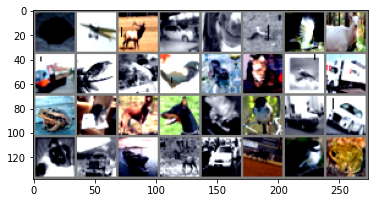

In [7]:
## THIS WILL GO IN UTIL FILE

import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(32)))

### 6. Define a Convolution Neural Network
Import the model from the model_vanilla.py file which contains the model


In [9]:
# Custom model file
# from model_vanilla import Net

from model_100 import Net

In [10]:
# Model Summary
from torchsummary import summary

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Net().to(device)
print(summary(model, (3,32,32)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             432
              ReLU-2           [-1, 16, 32, 32]               0
       BatchNorm2d-3           [-1, 16, 32, 32]              32
           Dropout-4           [-1, 16, 32, 32]               0
            Conv2d-5           [-1, 16, 32, 32]           2,304
              ReLU-6           [-1, 16, 32, 32]               0
       BatchNorm2d-7           [-1, 16, 32, 32]              32
           Dropout-8           [-1, 16, 32, 32]               0
            Conv2d-9           [-1, 32, 32, 32]           4,608
             ReLU-10           [-1, 32, 32, 32]               0
      BatchNorm2d-11           [-1, 32, 32, 32]              64
          Dropout-12           [-1, 32, 32, 32]               0
           Conv2d-13           [-1, 32, 32, 32]           9,216
             ReLU-14           [-1, 32,

### 7. Define a Loss function and optimizer

Let's use a Classification Cross-Entropy loss and SGD with momentum.



In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.001)

### 8. Train and Test the network


This is when things start to get interesting.
We simply have to loop over our data iterator, and feed the inputs to the
network and optimize.



In [12]:
# Import train and test library
from train import train
from test import test

# Import results library for Misclassified images and Plots
from results import plot_misclassified_images, plot_graph

In [13]:
# Train the network for given number of epochs

epochs  = 50
test_losses = []
test_accs = []
misclassified_imgs = []

for epoch in range(epochs):
      print("EPOCH:", epoch+1)
      train(model, device, trainloader, criterion, optimizer, epoch)
      test(model, device, testloader, criterion, classes, test_losses, test_accs, misclassified_imgs, epoch==epochs-1)

  0%|          | 0/1563 [00:00<?, ?it/s]

EPOCH: 1


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Loss=1.657034993171692 Batch_id=1562 Accuracy=35.58: 100%|██████████| 1563/1563 [00:26<00:00, 58.12it/s]
  0%|          | 0/1563 [00:00<?, ?it/s]

Test set: Average loss: 0.0435, Accuracy: 4865/10000 (48.65%)

EPOCH: 2


Loss=1.4601999521255493 Batch_id=1562 Accuracy=49.07: 100%|██████████| 1563/1563 [00:27<00:00, 56.74it/s]
  0%|          | 0/1563 [00:00<?, ?it/s]

Test set: Average loss: 0.0363, Accuracy: 5836/10000 (58.36%)

EPOCH: 3


Loss=1.1576606035232544 Batch_id=1562 Accuracy=56.09: 100%|██████████| 1563/1563 [00:28<00:00, 54.16it/s]
  0%|          | 0/1563 [00:00<?, ?it/s]

Test set: Average loss: 0.0332, Accuracy: 6169/10000 (61.69%)

EPOCH: 4


Loss=1.7301063537597656 Batch_id=1562 Accuracy=59.97: 100%|██████████| 1563/1563 [00:26<00:00, 58.16it/s]
  0%|          | 0/1563 [00:00<?, ?it/s]

Test set: Average loss: 0.0296, Accuracy: 6636/10000 (66.36%)

EPOCH: 5


Loss=0.9703230857849121 Batch_id=1562 Accuracy=62.49: 100%|██████████| 1563/1563 [00:26<00:00, 58.63it/s]
  0%|          | 0/1563 [00:00<?, ?it/s]

Test set: Average loss: 0.0278, Accuracy: 6839/10000 (68.39%)

EPOCH: 6


Loss=0.7986265420913696 Batch_id=1562 Accuracy=64.31: 100%|██████████| 1563/1563 [00:26<00:00, 58.73it/s]
  0%|          | 0/1563 [00:00<?, ?it/s]

Test set: Average loss: 0.0264, Accuracy: 7026/10000 (70.26%)

EPOCH: 7


Loss=0.551543653011322 Batch_id=1562 Accuracy=66.85: 100%|██████████| 1563/1563 [00:26<00:00, 58.88it/s]
  0%|          | 0/1563 [00:00<?, ?it/s]

Test set: Average loss: 0.0242, Accuracy: 7268/10000 (72.68%)

EPOCH: 8


Loss=0.8333700895309448 Batch_id=1562 Accuracy=68.49: 100%|██████████| 1563/1563 [00:26<00:00, 58.70it/s]
  0%|          | 0/1563 [00:00<?, ?it/s]

Test set: Average loss: 0.0234, Accuracy: 7428/10000 (74.28%)

EPOCH: 9


Loss=1.0553088188171387 Batch_id=1562 Accuracy=69.99: 100%|██████████| 1563/1563 [00:26<00:00, 58.82it/s]
  0%|          | 0/1563 [00:00<?, ?it/s]

Test set: Average loss: 0.0221, Accuracy: 7533/10000 (75.33%)

EPOCH: 10


Loss=0.9065746665000916 Batch_id=1562 Accuracy=71.23: 100%|██████████| 1563/1563 [00:26<00:00, 58.79it/s]
  0%|          | 0/1563 [00:00<?, ?it/s]

Test set: Average loss: 0.0226, Accuracy: 7480/10000 (74.80%)

EPOCH: 11


Loss=0.9398098587989807 Batch_id=1562 Accuracy=72.14: 100%|██████████| 1563/1563 [00:26<00:00, 58.38it/s]
  0%|          | 0/1563 [00:00<?, ?it/s]

Test set: Average loss: 0.0207, Accuracy: 7720/10000 (77.20%)

EPOCH: 12


Loss=0.9741359949111938 Batch_id=1562 Accuracy=72.91: 100%|██████████| 1563/1563 [00:27<00:00, 56.98it/s]
  0%|          | 0/1563 [00:00<?, ?it/s]

Test set: Average loss: 0.0208, Accuracy: 7705/10000 (77.05%)

EPOCH: 13


Loss=0.5067805051803589 Batch_id=1562 Accuracy=73.58: 100%|██████████| 1563/1563 [00:26<00:00, 58.53it/s]
  0%|          | 0/1563 [00:00<?, ?it/s]

Test set: Average loss: 0.0200, Accuracy: 7794/10000 (77.94%)

EPOCH: 14


Loss=0.6866549253463745 Batch_id=1562 Accuracy=74.23: 100%|██████████| 1563/1563 [00:26<00:00, 58.96it/s]
  0%|          | 0/1563 [00:00<?, ?it/s]

Test set: Average loss: 0.0189, Accuracy: 7883/10000 (78.83%)

EPOCH: 15


Loss=0.9837902188301086 Batch_id=1562 Accuracy=74.53: 100%|██████████| 1563/1563 [00:26<00:00, 58.04it/s]
  0%|          | 0/1563 [00:00<?, ?it/s]

Test set: Average loss: 0.0187, Accuracy: 7964/10000 (79.64%)

EPOCH: 16


Loss=0.889589786529541 Batch_id=1562 Accuracy=75.23: 100%|██████████| 1563/1563 [00:26<00:00, 58.40it/s]
  0%|          | 0/1563 [00:00<?, ?it/s]

Test set: Average loss: 0.0187, Accuracy: 7945/10000 (79.45%)

EPOCH: 17


Loss=0.8083205223083496 Batch_id=1562 Accuracy=75.79: 100%|██████████| 1563/1563 [00:26<00:00, 58.85it/s]
  0%|          | 0/1563 [00:00<?, ?it/s]

Test set: Average loss: 0.0177, Accuracy: 8077/10000 (80.77%)

EPOCH: 18


Loss=0.49241864681243896 Batch_id=1562 Accuracy=75.93: 100%|██████████| 1563/1563 [00:26<00:00, 58.11it/s]
  0%|          | 0/1563 [00:00<?, ?it/s]

Test set: Average loss: 0.0182, Accuracy: 8030/10000 (80.30%)

EPOCH: 19


Loss=0.3362289071083069 Batch_id=1562 Accuracy=76.36: 100%|██████████| 1563/1563 [00:26<00:00, 58.12it/s]
  0%|          | 0/1563 [00:00<?, ?it/s]

Test set: Average loss: 0.0180, Accuracy: 7989/10000 (79.89%)

EPOCH: 20


Loss=0.698112428188324 Batch_id=1562 Accuracy=76.85: 100%|██████████| 1563/1563 [00:26<00:00, 58.45it/s]
  0%|          | 0/1563 [00:00<?, ?it/s]

Test set: Average loss: 0.0175, Accuracy: 8079/10000 (80.79%)

EPOCH: 21


Loss=0.5594981908798218 Batch_id=1562 Accuracy=77.33: 100%|██████████| 1563/1563 [00:27<00:00, 57.20it/s]
  0%|          | 0/1563 [00:00<?, ?it/s]

Test set: Average loss: 0.0167, Accuracy: 8158/10000 (81.58%)

EPOCH: 22


Loss=1.0490589141845703 Batch_id=1562 Accuracy=77.32: 100%|██████████| 1563/1563 [00:27<00:00, 57.47it/s]
  0%|          | 0/1563 [00:00<?, ?it/s]

Test set: Average loss: 0.0168, Accuracy: 8169/10000 (81.69%)

EPOCH: 23


Loss=0.455313503742218 Batch_id=1562 Accuracy=77.93: 100%|██████████| 1563/1563 [00:27<00:00, 56.86it/s]
  0%|          | 0/1563 [00:00<?, ?it/s]

Test set: Average loss: 0.0178, Accuracy: 8060/10000 (80.60%)

EPOCH: 24


Loss=0.7468734383583069 Batch_id=1562 Accuracy=77.99: 100%|██████████| 1563/1563 [00:27<00:00, 57.74it/s]
  0%|          | 0/1563 [00:00<?, ?it/s]

Test set: Average loss: 0.0161, Accuracy: 8240/10000 (82.40%)

EPOCH: 25


Loss=0.4109625220298767 Batch_id=1562 Accuracy=78.40: 100%|██████████| 1563/1563 [00:27<00:00, 57.66it/s]
  0%|          | 0/1563 [00:00<?, ?it/s]

Test set: Average loss: 0.0162, Accuracy: 8261/10000 (82.61%)

EPOCH: 26


Loss=0.733120858669281 Batch_id=1562 Accuracy=78.46: 100%|██████████| 1563/1563 [00:27<00:00, 57.70it/s]
  0%|          | 0/1563 [00:00<?, ?it/s]

Test set: Average loss: 0.0159, Accuracy: 8267/10000 (82.67%)

EPOCH: 27


Loss=0.7229576706886292 Batch_id=1562 Accuracy=78.92: 100%|██████████| 1563/1563 [00:27<00:00, 57.67it/s]
  0%|          | 0/1563 [00:00<?, ?it/s]

Test set: Average loss: 0.0157, Accuracy: 8306/10000 (83.06%)

EPOCH: 28


Loss=0.5677601099014282 Batch_id=1562 Accuracy=78.87: 100%|██████████| 1563/1563 [00:27<00:00, 57.12it/s]
  0%|          | 0/1563 [00:00<?, ?it/s]

Test set: Average loss: 0.0156, Accuracy: 8309/10000 (83.09%)

EPOCH: 29


Loss=0.5906609892845154 Batch_id=1562 Accuracy=78.96: 100%|██████████| 1563/1563 [00:27<00:00, 56.84it/s]
  0%|          | 0/1563 [00:00<?, ?it/s]

Test set: Average loss: 0.0156, Accuracy: 8297/10000 (82.97%)

EPOCH: 30


Loss=0.6874144673347473 Batch_id=1562 Accuracy=79.21: 100%|██████████| 1563/1563 [00:27<00:00, 57.44it/s]
  0%|          | 0/1563 [00:00<?, ?it/s]

Test set: Average loss: 0.0159, Accuracy: 8259/10000 (82.59%)

EPOCH: 31


Loss=1.0044867992401123 Batch_id=1562 Accuracy=79.63: 100%|██████████| 1563/1563 [00:26<00:00, 58.11it/s]
  0%|          | 0/1563 [00:00<?, ?it/s]

Test set: Average loss: 0.0148, Accuracy: 8387/10000 (83.87%)

EPOCH: 32


Loss=0.4441532492637634 Batch_id=1562 Accuracy=79.28: 100%|██████████| 1563/1563 [00:27<00:00, 56.64it/s]
  0%|          | 0/1563 [00:00<?, ?it/s]

Test set: Average loss: 0.0152, Accuracy: 8318/10000 (83.18%)

EPOCH: 33


Loss=0.7691777944564819 Batch_id=1562 Accuracy=79.50: 100%|██████████| 1563/1563 [00:27<00:00, 57.21it/s]
  0%|          | 0/1563 [00:00<?, ?it/s]

Test set: Average loss: 0.0152, Accuracy: 8366/10000 (83.66%)

EPOCH: 34


Loss=0.5057022571563721 Batch_id=1562 Accuracy=80.09: 100%|██████████| 1563/1563 [00:27<00:00, 57.58it/s]
  0%|          | 0/1563 [00:00<?, ?it/s]

Test set: Average loss: 0.0151, Accuracy: 8349/10000 (83.49%)

EPOCH: 35


Loss=0.5424346327781677 Batch_id=1562 Accuracy=80.19: 100%|██████████| 1563/1563 [00:27<00:00, 57.00it/s]
  0%|          | 0/1563 [00:00<?, ?it/s]

Test set: Average loss: 0.0154, Accuracy: 8319/10000 (83.19%)

EPOCH: 36


Loss=0.3133087158203125 Batch_id=1562 Accuracy=80.03: 100%|██████████| 1563/1563 [00:27<00:00, 57.09it/s]
  0%|          | 0/1563 [00:00<?, ?it/s]

Test set: Average loss: 0.0152, Accuracy: 8344/10000 (83.44%)

EPOCH: 37


Loss=0.6813870668411255 Batch_id=1562 Accuracy=80.15: 100%|██████████| 1563/1563 [00:27<00:00, 57.17it/s]
  0%|          | 0/1563 [00:00<?, ?it/s]

Test set: Average loss: 0.0143, Accuracy: 8436/10000 (84.36%)

EPOCH: 38


Loss=0.47147199511528015 Batch_id=1562 Accuracy=80.47: 100%|██████████| 1563/1563 [00:27<00:00, 56.80it/s]
  0%|          | 0/1563 [00:00<?, ?it/s]

Test set: Average loss: 0.0148, Accuracy: 8402/10000 (84.02%)

EPOCH: 39


Loss=0.3718791604042053 Batch_id=1562 Accuracy=80.43: 100%|██████████| 1563/1563 [00:27<00:00, 57.69it/s]
  0%|          | 0/1563 [00:00<?, ?it/s]

Test set: Average loss: 0.0145, Accuracy: 8422/10000 (84.22%)

EPOCH: 40


Loss=0.5683472156524658 Batch_id=1562 Accuracy=80.74: 100%|██████████| 1563/1563 [00:27<00:00, 57.16it/s]
  0%|          | 0/1563 [00:00<?, ?it/s]

Test set: Average loss: 0.0144, Accuracy: 8451/10000 (84.51%)

EPOCH: 41


Loss=0.2734573483467102 Batch_id=1562 Accuracy=80.71: 100%|██████████| 1563/1563 [00:27<00:00, 57.31it/s]
  0%|          | 0/1563 [00:00<?, ?it/s]

Test set: Average loss: 0.0141, Accuracy: 8463/10000 (84.63%)

EPOCH: 42


Loss=0.25061294436454773 Batch_id=1562 Accuracy=80.86: 100%|██████████| 1563/1563 [00:27<00:00, 56.48it/s]
  0%|          | 0/1563 [00:00<?, ?it/s]

Test set: Average loss: 0.0142, Accuracy: 8450/10000 (84.50%)

EPOCH: 43


Loss=0.34434863924980164 Batch_id=1562 Accuracy=80.77: 100%|██████████| 1563/1563 [00:27<00:00, 56.76it/s]
  0%|          | 0/1563 [00:00<?, ?it/s]

Test set: Average loss: 0.0141, Accuracy: 8475/10000 (84.75%)

EPOCH: 44


Loss=0.3849093019962311 Batch_id=1562 Accuracy=81.13: 100%|██████████| 1563/1563 [00:27<00:00, 57.09it/s]
  0%|          | 0/1563 [00:00<?, ?it/s]

Test set: Average loss: 0.0143, Accuracy: 8435/10000 (84.35%)

EPOCH: 45


Loss=0.3397027254104614 Batch_id=1562 Accuracy=80.93: 100%|██████████| 1563/1563 [00:27<00:00, 56.48it/s]
  0%|          | 0/1563 [00:00<?, ?it/s]


Accuracy of plane : 89 %
Accuracy of   car : 97 %
Accuracy of  bird : 83 %
Accuracy of   cat : 65 %
Accuracy of  deer : 79 %
Accuracy of   dog : 75 %
Accuracy of  frog : 85 %
Accuracy of horse : 89 %
Accuracy of  ship : 92 %
Accuracy of truck : 86 %

Test set: Average loss: 0.0139, Accuracy: 8505/10000 (85.05%)

EPOCH: 46


Loss=0.3810938894748688 Batch_id=1562 Accuracy=81.50: 100%|██████████| 1563/1563 [00:27<00:00, 56.11it/s]
  0%|          | 0/1563 [00:00<?, ?it/s]

Test set: Average loss: 0.0141, Accuracy: 8485/10000 (84.85%)

EPOCH: 47


Loss=1.0998165607452393 Batch_id=1562 Accuracy=81.40: 100%|██████████| 1563/1563 [00:27<00:00, 56.35it/s]
  0%|          | 0/1563 [00:00<?, ?it/s]

Test set: Average loss: 0.0145, Accuracy: 8443/10000 (84.43%)

EPOCH: 48


Loss=0.4281746745109558 Batch_id=1562 Accuracy=81.38: 100%|██████████| 1563/1563 [00:28<00:00, 55.55it/s]
  0%|          | 0/1563 [00:00<?, ?it/s]


Accuracy of plane : 85 %
Accuracy of   car : 97 %
Accuracy of  bird : 75 %
Accuracy of   cat : 65 %
Accuracy of  deer : 79 %
Accuracy of   dog : 76 %
Accuracy of  frog : 89 %
Accuracy of horse : 97 %
Accuracy of  ship : 93 %
Accuracy of truck : 94 %

Test set: Average loss: 0.0137, Accuracy: 8511/10000 (85.11%)

EPOCH: 49


Loss=0.4234677851200104 Batch_id=1562 Accuracy=81.40: 100%|██████████| 1563/1563 [00:27<00:00, 56.38it/s]
  0%|          | 0/1563 [00:00<?, ?it/s]

Test set: Average loss: 0.0141, Accuracy: 8479/10000 (84.79%)

EPOCH: 50


Loss=0.4623173177242279 Batch_id=1562 Accuracy=81.57: 100%|██████████| 1563/1563 [00:27<00:00, 55.95it/s]


Test set: Average loss: 0.0139, Accuracy: 8485/10000 (84.85%)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

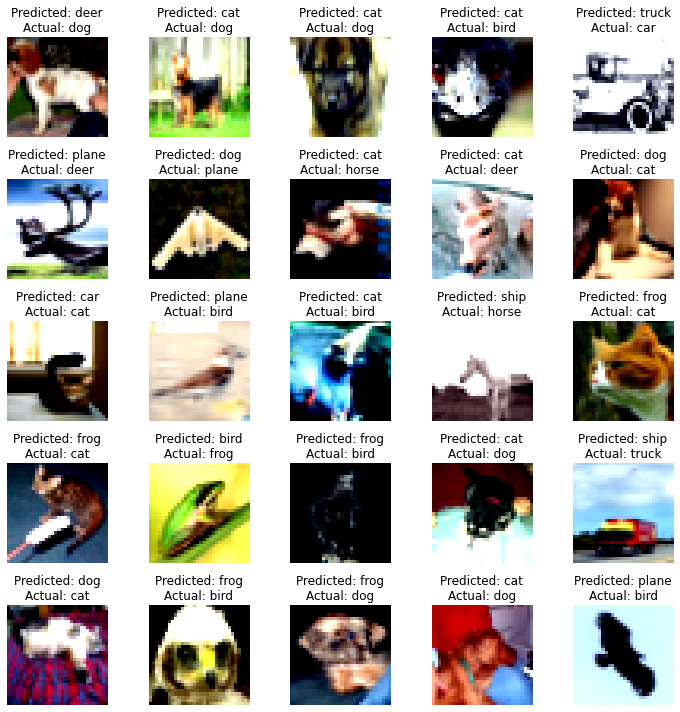

In [14]:
plot_misclassified_images(misclassified_imgs, classes, "misclassified_imgs.png")

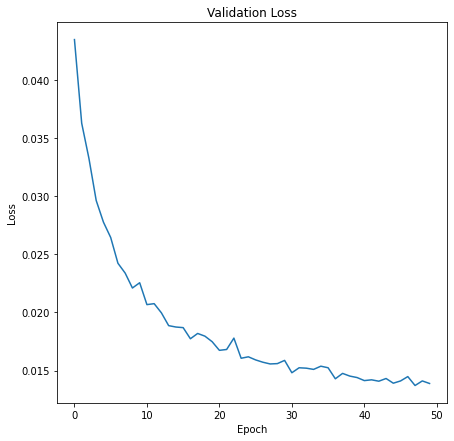

In [15]:
plot_graph(test_losses, "Loss")

In [16]:
plot_graph(train_losses, "Loss")

NameError: ignored